In [1]:
import pickle
import gzip
import numpy as np

def load_data():
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e


In [13]:
training_data, validation_data, test_data = load_data_wrapper()

### Explore the data a little bit

In [14]:
tr_data_list = list(training_data)

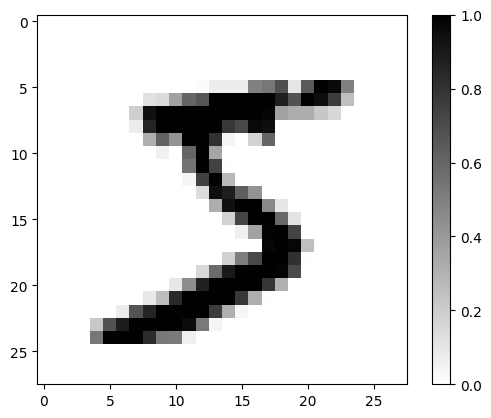

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 创建长度为784的示例数组
a = np.array(tr_data_list[0][0])

# 将一维数组 a 重塑为 28x28 的二维数组
image_matrix = a.reshape((28, 28))

# 使用 matplotlib 绘制灰度图
plt.imshow(image_matrix, cmap='gray_r', vmin=1, vmax=0)

# 显示颜色条
plt.colorbar()

# 显示图像
plt.show()


In [35]:
tr_data_list[0][1]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

### Build NN

In [3]:
import random
import numpy as np

class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        training_data = list(training_data)
        n = len(training_data)

        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {} : {} / {}".format(j,self.evaluate(test_data),n_test))
            else:
                print("Epoch {} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        #sum over all the nabla_b and nabla_w, and then divided by len(mini_batch)
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))


In [5]:
net = Network([784, 30, 10])

In [6]:
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0 : 9128 / 10000
Epoch 1 : 9249 / 10000
Epoch 2 : 9370 / 10000
Epoch 3 : 9367 / 10000
Epoch 4 : 9419 / 10000
Epoch 5 : 9429 / 10000
Epoch 6 : 9457 / 10000
Epoch 7 : 9432 / 10000
Epoch 8 : 9483 / 10000
Epoch 9 : 9467 / 10000
Epoch 10 : 9460 / 10000
Epoch 11 : 9487 / 10000
Epoch 12 : 9467 / 10000
Epoch 13 : 9527 / 10000
Epoch 14 : 9504 / 10000
Epoch 15 : 9535 / 10000
Epoch 16 : 9507 / 10000
Epoch 17 : 9520 / 10000
Epoch 18 : 9528 / 10000
Epoch 19 : 9529 / 10000
Epoch 20 : 9521 / 10000
Epoch 21 : 9524 / 10000
Epoch 22 : 9519 / 10000
Epoch 23 : 9519 / 10000
Epoch 24 : 9544 / 10000
Epoch 25 : 9552 / 10000
Epoch 26 : 9546 / 10000
Epoch 27 : 9535 / 10000
Epoch 28 : 9561 / 10000
Epoch 29 : 9537 / 10000


### Now change to cross-entropy cost function

In [3]:
"""network2.py
~~~~~~~~~~~~~~

An improved version of network.py, implementing the stochastic
gradient descent learning algorithm for a feedforward neural network.
Improvements include the addition of the cross-entropy cost function,
regularization, and better initialization of network weights.  Note
that I have focused on making the code simple, easily readable, and
easily modifiable.  It is not optimized, and omits many desirable
features.

"""

#### Libraries
# Standard library
import json
import random
import sys

# Third-party libraries
import numpy as np


#### Define the quadratic and cross-entropy cost functions

class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.

        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)


class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).

        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        return (a-y)


#### Main Network class
class Network2(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).

        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            early_stopping_n = 0):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.

        """

        # early stopping functionality:
        best_accuracy=1

        training_data = list(training_data)
        n = len(training_data)

        if evaluation_data:
            evaluation_data = list(evaluation_data)
            n_data = len(evaluation_data)

        # early stopping functionality:
        best_accuracy=0
        no_accuracy_change=0

        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))

            print("Epoch %s training complete" % j)

            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))

            # Early stopping:
            if early_stopping_n > 0:
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    no_accuracy_change = 0
                    #print("Early-stopping: Best so far {}".format(best_accuracy))
                else:
                    no_accuracy_change += 1

                if (no_accuracy_change == early_stopping_n):
                    #print("Early-stopping: No accuracy change in last epochs: {}".format(early_stopping_n))
                    return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy

        return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.

        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]

        result_accuracy = sum(int(x == y) for (x, y) in results)
        return result_accuracy

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
            cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights) # '**' - to the power of.
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

#### Loading a Network
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.

    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

#### Miscellaneous functions
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.

    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))


In [ ]:
training_data, validation_data, test_data = load_data_wrapper()
net = Network2([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
net.SGD(training_data, 30, 10, 0.5, evaluation_data=test_data,monitor_evaluation_accuracy=True,monitor_evaluation_cost = True,monitor_training_accuracy = True, monitor_training_cost = True)

### Test about overfitting problem

In [4]:
training_data, validation_data, test_data = load_data_wrapper()
net = Network2([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
evaluation_cost, evaluation_accuracy, training_cost, training_accuracy = net.SGD(list(training_data)[:1000], 400, 10, 0.5, evaluation_data=test_data,monitor_evaluation_accuracy=True,monitor_evaluation_cost = True,monitor_training_accuracy = True, monitor_training_cost = True)

Epoch 0 training complete
Cost on training data: 1.8974236788290824
Accuracy on training data: 640 / 1000
Cost on evaluation data: 2.213467764479541
Accuracy on evaluation data: 5506 / 10000
Epoch 1 training complete
Cost on training data: 1.448522846976628
Accuracy on training data: 759 / 1000
Cost on evaluation data: 1.881772937767369
Accuracy on evaluation data: 6335 / 10000
Epoch 2 training complete
Cost on training data: 1.1546038997399446
Accuracy on training data: 828 / 1000
Cost on evaluation data: 1.6384550077303923
Accuracy on evaluation data: 6984 / 10000
Epoch 3 training complete
Cost on training data: 0.979985864646304
Accuracy on training data: 860 / 1000
Cost on evaluation data: 1.535535381188563
Accuracy on evaluation data: 7191 / 10000
Epoch 4 training complete
Cost on training data: 0.8818575147018609
Accuracy on training data: 862 / 1000
Cost on evaluation data: 1.5232258785196722
Accuracy on evaluation data: 7184 / 10000
Epoch 5 training complete
Cost on training da

### Plot some cost 

In [18]:

def make_plots(num_epochs=400, 
               training_cost_xmin=200, 
               test_accuracy_xmin=200, 
               test_cost_xmin=0, 
               training_accuracy_xmin=0,
               training_set_size=1000):
    test_cost, test_accuracy= evaluation_cost, evaluation_accuracy
    
    plot_training_cost(training_cost, num_epochs, training_cost_xmin)
    plot_test_accuracy(test_accuracy, num_epochs, test_accuracy_xmin)
    plot_test_cost(test_cost, num_epochs, test_cost_xmin)
    plot_training_accuracy(training_accuracy, num_epochs, 
                           training_accuracy_xmin, training_set_size)

def plot_training_cost(training_cost, num_epochs, training_cost_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(training_cost_xmin, num_epochs), 
            training_cost[training_cost_xmin:num_epochs],
            color='#2A6EA6')
    ax.set_xlim([training_cost_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Cost on the training data')
    plt.show()

def plot_test_accuracy(test_accuracy, num_epochs, test_accuracy_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(test_accuracy_xmin, num_epochs), 
            [accuracy/100.0 
             for accuracy in test_accuracy[test_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([test_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Accuracy (%) on the test data')
    plt.show()

def plot_test_cost(test_cost, num_epochs, test_cost_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(test_cost_xmin, num_epochs), 
            test_cost[test_cost_xmin:num_epochs],
            color='#2A6EA6')
    ax.set_xlim([test_cost_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Cost on the test data')
    plt.show()

def plot_training_accuracy(training_accuracy, num_epochs, 
                           training_accuracy_xmin, training_set_size):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(training_accuracy_xmin, num_epochs), 
            [accuracy*100.0/training_set_size 
             for accuracy in training_accuracy[training_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([training_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Accuracy (%) on the training data')
    plt.show()


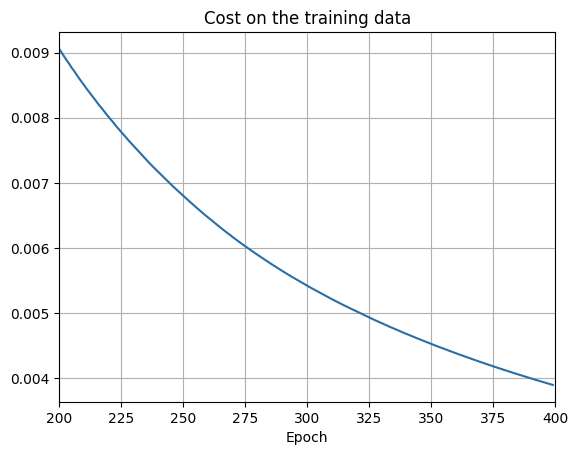

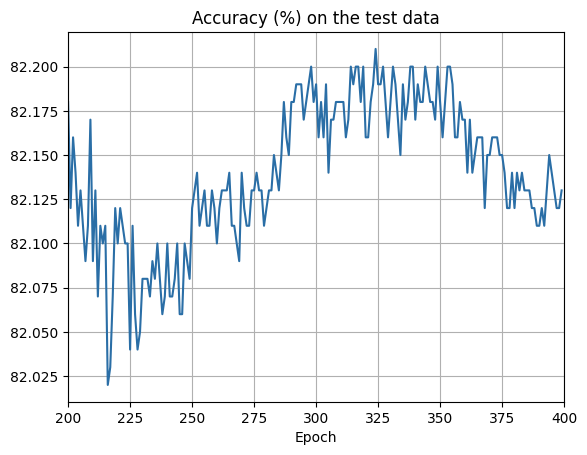

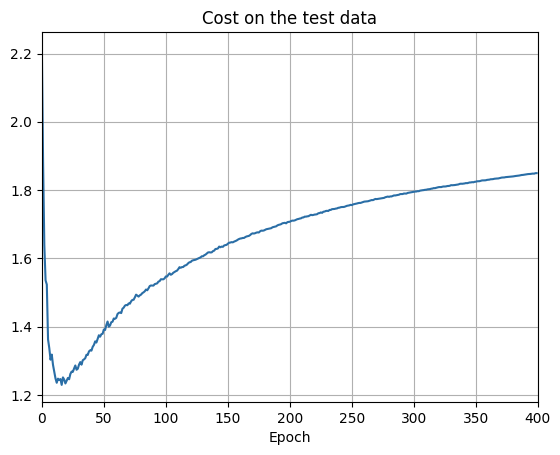

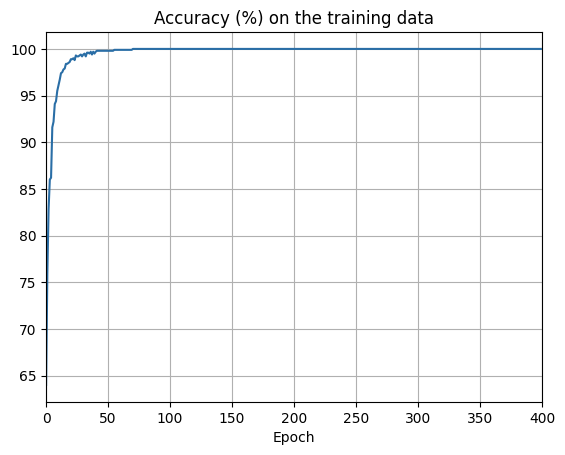

In [19]:
make_plots()

### Now try to implement regularization techniques

In [ ]:
training_data, validation_data, test_data = load_data_wrapper() 
net = Network2([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
net.SGD(list(training_data)[:1000], 400, 10, 0.5,
evaluation_data=test_data, lmbda = 0.1,
monitor_evaluation_cost=True, monitor_evaluation_accuracy=True,
monitor_training_cost=True, monitor_training_accuracy=True)